### Specific Test VI. SSL on Real Dataset

#### **Name:** Yashwardhan Deshmukh [yaashwardhan@gmail.com](mailto:yaashwardhan@gmail.com)

---

**Task:** Build a Self-Supervised Learning model for classifying the images into lenses using PyTorch or Keras. Pick the most appropriate approach and discuss your strategy. 

**Dataset:** https://drive.google.com/file/d/1aafE2nDp7S6j59sZcBIzP3FnQxVCmHCx/view

**Dataset Description:** The Dataset consists of two classes, strong lensing images with lenses and non-lenses in npy format. For non-lensing images, the images start with nl_. These images are from the Hubble Space Telescope. 

**Evaluation Metrics:** ROC curve (Receiver Operating Characteristic curve) and AUC score (Area Under the ROC Curve). Although the dataset is small and results may not be perfect, the pipeline should be such that with more data, the model could achieve high performance.

--- 

*Trained model for this task can be found in the respective folder in [HERE](https://drive.google.com/drive/folders/1lJHjNkfqu4mm69brzNPIFmywLEF_tvma?usp=sharing)*

**Strategy**: First train a baseline ResNet50 to see how to dataset performs. Then pretrain using Rotation Pretext Task and a Gaussian Pretext Task and finetune both of them. Then compare them with the baseline using ROC and AUC.

**Results:** Even though the dataset is small, both the self-supervised methods that generally thrive on large datasets seem to outperform the baseline with as little pretraining as 20 epochs. 

In [ ]:
import os
import keras
import pickle
import random
import imageio
import numpy as np
import pandas as pd
from PIL import Image
import tensorflow as tf
import matplotlib.cm as cm
from scipy.ndimage import zoom
import matplotlib.pyplot as plt
from keras.utils import Sequence
from keras.optimizers import Adam
from keras import optimizers, metrics
from keras.utils import to_categorical
from keras.callbacks import ReduceLROnPlateau
from keras import layers, models, applications
from sklearn.preprocessing import label_binarize
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from keras.models import load_model, Model, Sequential
from tensorflow.keras.applications import ResNet50
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Dense, GlobalAveragePooling2D, PReLU
from sklearn.metrics import confusion_matrix, roc_curve, auc, accuracy_score, roc_auc_score, classification_report


Shape of Lensing: (334, 334)
Shape of Non-Lensing: (334, 334)


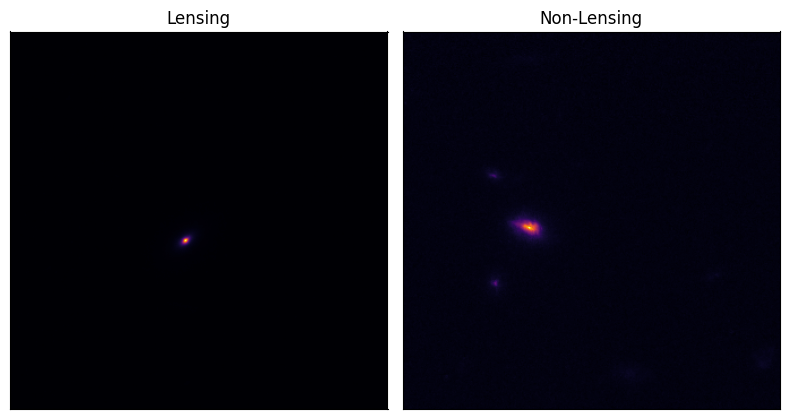

In [2]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(8, 5))
classes = ['Lensing', 'Non-Lensing']
images_to_load = {'Lensing': None, 'Non-Lensing': None}
base_dir = '/kaggle/input/gsoc-ssl-2024-test/real_hst/'
for file_name in os.listdir(base_dir):
    if file_name.startswith('nl_') and images_to_load['Non-Lensing'] is None:
        images_to_load['Non-Lensing'] = os.path.join(base_dir, file_name)
    elif not file_name.startswith('nl_') and images_to_load['Lensing'] is None:
        images_to_load['Lensing'] = os.path.join(base_dir, file_name)
    if all(images_to_load.values()):
        break

for i, (class_type, file_path) in enumerate(images_to_load.items()):
    if file_path is not None:
        loaded_image = np.load(file_path, allow_pickle=True)
        print(f'Shape of {class_type}: {loaded_image.shape}')
        axs[i].imshow(loaded_image, cmap='inferno')
        axs[i].set_title(class_type)
        axs[i].set_xticks([])
        axs[i].set_yticks([])
    else:
        print(f"No example found for class {class_type}")

plt.tight_layout()
plt.show()

In [3]:
# Algorithm hyperparameters
input_shape = (334, 334, 1)
num_epochs = 20
batch_size = 128
width = 167
temperature = 0.1
queue_size = 10000

contrastive_augmentation_rotation = {"factor": 0.5,"name": "contrastive_augmenter_rotation"}
contrastive_augmentation_gaussian = {"std_dev": 0.1,"name": "contrastive_augmenter_gaussian"} # Std_dev = 0.04 for rgb and 0.001 for 1 channel


# classification_augmentation = {"brightness": 0.1,"name": "classification_augmenter","scale": (0.5, 3.0),}

# total_samples = sum([len(files) for r, d, files in os.walk(data_path)])
# steps_per_epoch = total_samples // batch_size
# validation_steps = total_samples // batch_size


In [4]:
classes = ['lensing', 'non-lensing']
class_indices = {class_name: idx for idx, class_name in enumerate(classes)}


def image_generator(files, label_type, batch_size=batch_size):
    while True:
        batch_paths = np.random.choice(a=files, size=batch_size)
        batch_input = []
        batch_output = []

        for input_path in batch_paths:
            file_name = os.path.basename(input_path)
            
            class_name = 'non-lensing' if file_name.startswith('nl_') else 'lensing'
            label = class_indices[class_name]
            
            # Load the image and add a channel dimension
            input = np.load(input_path, allow_pickle=True)[..., np.newaxis]
            input = np.nan_to_num(input)  # This replaces NaNs with 0

            batch_input.append(input)
            batch_output.append(label)

        batch_x = np.array(batch_input)
        if label_type == 'one_hot':
            batch_y = to_categorical(batch_output, num_classes=len(classes))
        elif label_type == 'label':
            batch_y = np.array(batch_output)
        yield(batch_x, batch_y)


data_path = '/kaggle/input/gsoc-ssl-2024-test/real_hst/'
file_paths = [os.path.join(data_path, file) for file in os.listdir(data_path)]


train_files, test_files = train_test_split(file_paths, test_size=0.1, random_state=42)


batch_size = 8

train_generator_one_hot = image_generator(train_files, 'one_hot', batch_size)
test_generator_one_hot = image_generator(test_files, 'one_hot', batch_size)
train_generator_label = image_generator(train_files, 'label', batch_size)
test_generator_label = image_generator(test_files, 'label', batch_size)

total_samples = len(train_files)
steps_per_epoch = total_samples // batch_size
total_validation_samples = len(test_files)
validation_steps = total_validation_samples // batch_size

Array Range: -0.2401106059551239, 38.35681915283203
Sample Image of label: lensing


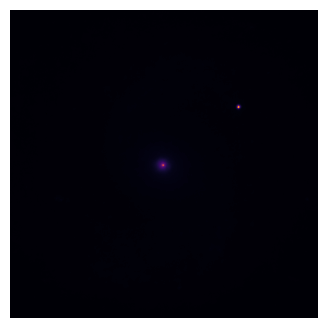

Image shape: (8, 334, 334, 1)
Label shape: (8,)


In [5]:
image_sample, label_sample = next(train_generator_label)

class_names = ['lensing', 'non-lensing']
sample_label_index = np.argmax(label_sample[0])  
print(f'Array Range: {np.min(image_sample[0])}, {np.max(image_sample[0])}')
print(f'Sample Image of label: {class_names[sample_label_index]}')

plt.figure(figsize=(4, 4))
plt.imshow(image_sample[0].squeeze(), cmap='inferno') 
plt.axis('off')
plt.show()

print(f'Image shape: {image_sample.shape}\nLabel shape: {label_sample.shape}')

In [6]:
class RandomResizedCrop(layers.Layer):
    def __init__(self, scale, ratio):
        super().__init__()
        self.scale = scale
        self.log_ratio = (tf.math.log(ratio[0]), tf.math.log(ratio[1]))

    def call(self, images):
        batch_size = tf.shape(images)[0]
        height = tf.shape(images)[1]
        width = tf.shape(images)[2]

        random_scales = tf.random.uniform((batch_size,), self.scale[0], self.scale[1])
        random_ratios = tf.exp(
            tf.random.uniform((batch_size,), self.log_ratio[0], self.log_ratio[1])
        )

        new_heights = tf.clip_by_value(tf.sqrt(random_scales / random_ratios), 0, 1)
        new_widths = tf.clip_by_value(tf.sqrt(random_scales * random_ratios), 0, 1)
        height_offsets = tf.random.uniform((batch_size,), 0, 1 - new_heights)
        width_offsets = tf.random.uniform((batch_size,), 0, 1 - new_widths)

        bounding_boxes = tf.stack(
            [
                height_offsets,
                width_offsets,
                height_offsets + new_heights,
                width_offsets + new_widths,
            ],
            axis=1,
        )
        images = tf.image.crop_and_resize(
            images, bounding_boxes, tf.range(batch_size), (height, width)
        )
        return images
    
class RandomGaussianNoise(layers.Layer):
    def __init__(self, std_dev):
        super().__init__()
        self.std_dev = std_dev

    def add_gaussian_noise(self, images):
        noise = tf.random.normal(shape=tf.shape(images), mean=0., stddev=self.std_dev)
        return tf.clip_by_value(images + noise, 0, 1)

    def call(self, images):
        images = self.add_gaussian_noise(images)
        return images

    
    
def get_augmenter_only_gaussian(std_dev, name):
    return keras.Sequential(
        [
            layers.Input(shape=input_shape),
            layers.Rescaling(1 / 255), # Only for Single Channel Images
#             layers.RandomRotation(1), # Not needed for now
            RandomGaussianNoise(std_dev=std_dev),
#             RandomResizedCrop(scale=scale, ratio=(3 / 4, 4 / 3)),
#             RandomBrightness(brightness=brightness),
        ],
        name=name,)

def get_augmenter_only_rotation(factor, name):
    return keras.Sequential(
        [
            layers.Input(shape=input_shape),
            layers.Rescaling(1 / 255), # Only for Single Channel Images
            layers.RandomRotation(factor), 
        ],
        name=name,)

class RandomBrightness(layers.Layer):
    def __init__(self, brightness):
        super().__init__()
        self.brightness = brightness
    def blend(self, images_1, images_2, ratios):
        return tf.clip_by_value(ratios * images_1 + (1.0 - ratios) * images_2, 0, 1)
    def random_brightness(self, images):
        # random interpolation/extrapolation between the image and darkness
        return self.blend(
            images,
            0,
            tf.random.uniform(
                (tf.shape(images)[0], 1, 1, 1), 1 - self.brightness, 1 + self.brightness),)
    def call(self, images):
        images = self.random_brightness(images)
        return images 

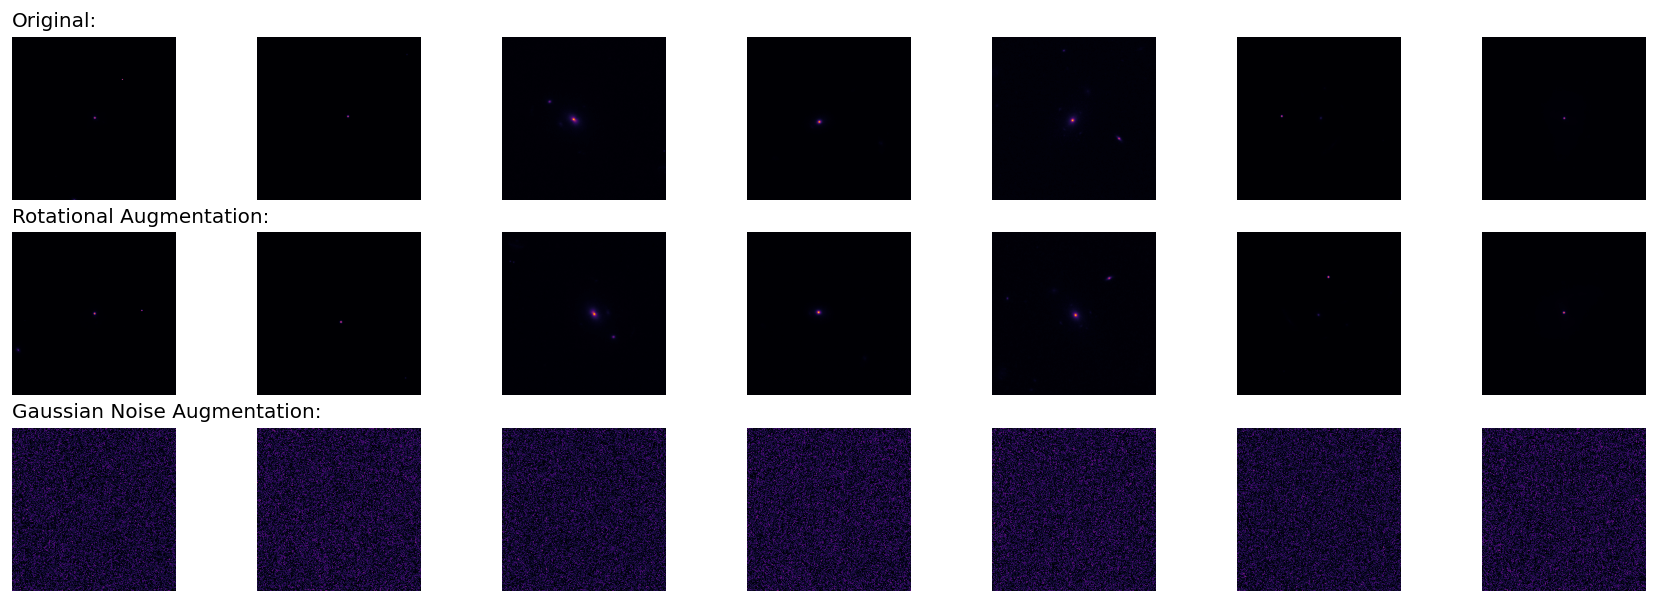

In [7]:
def visualize_augmentations(num_images):
    # Sample a batch from a dataset
    images = next(train_generator_label)[0][:num_images]
    augmented_images = zip(
        images,
        get_augmenter_only_rotation(**contrastive_augmentation_rotation)(images),
        get_augmenter_only_gaussian(**contrastive_augmentation_gaussian)(images),
    )
    row_titles = [
        "Original:",
        "Rotational Augmentation:",
        "Gaussian Noise Augmentation:",
    ]
    plt.figure(figsize=(18, 6), dpi=120)
    for column, image_row in enumerate(augmented_images):
        for row, image in enumerate(image_row):
            plt.subplot(3, num_images, row * num_images + column + 1)
            plt.imshow(image, cmap='inferno') #np.mean(image, axis=2)
            if column == 0:
                plt.title(row_titles[row], loc="left")
            plt.axis("off")

visualize_augmentations(num_images=7)

### Baseline Training


In [8]:
def get_encoder():
    resnet = applications.ResNet50(weights=None, include_top=False, input_shape=input_shape)
    model = models.Sequential([
          resnet,
          layers.Flatten(),
#           layers.Dense(width*8, activation='relu'), 
#           layers.BatchNormalization(), 
#           layers.Dropout(0.5),
        
          layers.Dense(width*4, activation='relu'),
          layers.BatchNormalization(),
          layers.Dropout(0.5),
        
          layers.Dense(width, activation='relu'),
          layers.BatchNormalization(),
          layers.Dropout(0.3),
    ])
    return model

In [9]:
baseline_model = keras.Sequential(
    [ 
        get_encoder(),
        layers.Dense(1, activation='sigmoid'), 
    ],
    name="baseline_model",
)

# Adjust the compilation step for binary classification
baseline_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    loss=keras.losses.BinaryCrossentropy(from_logits=False),  # Use BinaryCrossentropy for binary labels
    metrics=['accuracy', metrics.AUC(name='auc')]  
)

baseline_history = baseline_model.fit(
    train_generator_label, 
    steps_per_epoch=steps_per_epoch, 
    epochs=num_epochs, 
    validation_data=test_generator_label, 
    validation_steps=validation_steps
)
print(
    "Maximal validation accuracy: {:.2f}%".format(
        max(baseline_history.history["val_accuracy"]) * 100
    )
)

Epoch 1/20


I0000 00:00:1712061578.856900     255 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1712061578.944480     255 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


24/24 ━━━━━━━━━━━━━━━━━━━━ 92s 396ms/step - accuracy: 0.5223 - auc: 0.5588 - loss: 0.9199 - val_accuracy: 0.6250 - val_auc: 0.5833 - val_loss: 0.6725
Epoch 2/20


W0000 00:00:1712061588.142220     255 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 212ms/step - accuracy: 0.6233 - auc: 0.6842 - loss: 0.7248 - val_accuracy: 0.7500 - val_auc: 0.5000 - val_loss: 0.5958
Epoch 3/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 213ms/step - accuracy: 0.6049 - auc: 0.6441 - loss: 0.7741 - val_accuracy: 0.8750 - val_auc: 0.5000 - val_loss: 0.4513
Epoch 4/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 213ms/step - accuracy: 0.5973 - auc: 0.5228 - loss: 0.9357 - val_accuracy: 0.8125 - val_auc: 0.5000 - val_loss: 0.5673
Epoch 5/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 214ms/step - accuracy: 0.7391 - auc: 0.7673 - loss: 0.5551 - val_accuracy: 0.9375 - val_auc: 0.5000 - val_loss: 0.5290
Epoch 6/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 214ms/step - accuracy: 0.6342 - auc: 0.6889 - loss: 0.7202 - val_accuracy: 0.8125 - val_auc: 0.5000 - val_loss: 0.6263
Epoch 7/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 214ms/step - accuracy: 0.6344 - auc: 0.7228 - loss: 0.7135 - val_accuracy: 0.3750 - val_auc: 0.5000 - val_loss: 0.7083
Epoch 8/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 214ms/step

In [11]:
baseline_model.save_weights('baseline_model_resnet50.weights.h5')
# loaded_model = ContrastiveModel()
# pretraining_model.load_weights('pretraining_model.h5')
with open('baseline_history_resnet50.pkl', 'wb') as file:
    pickle.dump(baseline_history.history, file)

### Self-Supervised Contrastive Pretraining


c_loss: Contrastive loss. It is a measure of dissimilarity between pairs of augmented images. This loss is calculated using the InfoNCE (Information Noise-Contrastive Estimation) or NT-Xent (Normalized Temperature-Scaled Cross Entropy) loss, which encourages similar representations for augmented views of the same image and dissimilar representations for different images.

c_acc: Contrastive accuracy. It measures the accuracy of the contrastive predictions. In this case, it represents how well the SSL Real Datasets able to distinguish between the representations of augmented views of the same image and different images.

p_loss: Probe loss. It is the loss for the linear probe, which is used for evaluation and downstream classification tasks. The probe loss is calculated using the sparse categorical cross-entropy loss, comparing the predicted class probabilities with the true labels.

p_acc: Probe accuracy. It represents the accuracy of the linear probe, indicating how well the model performs on the downstream classification task.

### With only Rotational

In [14]:
# Define the contrastive model with model-subclassing
class ContrastiveModel(keras.Model):
    def __init__(self):
        super().__init__()

        self.temperature = temperature
        self.contrastive_augmenter = get_augmenter_only_rotation(**contrastive_augmentation_rotation)
        self.encoder = get_encoder()
        # Non-linear MLP as projection head
        self.projection_head = keras.Sequential(
            [
                keras.Input(shape=(width,)),
                layers.Dense(width, activation="relu"),
                layers.Dense(width),
            ],
            name="projection_head",
        )
        self.linear_probe = keras.Sequential(
            [layers.Input(shape=(width,)), layers.Dense(1, activation="sigmoid")], 
            name="linear_probe"
        )

        self.encoder.summary()
        self.projection_head.summary()
        self.linear_probe.summary()

    def compile(self, contrastive_optimizer, probe_optimizer, **kwargs):
        super().compile(**kwargs)

        self.contrastive_optimizer = contrastive_optimizer
        self.probe_optimizer = probe_optimizer

        self.probe_loss = keras.losses.BinaryCrossentropy(from_logits=False)

        self.contrastive_loss_tracker = keras.metrics.Mean(name="c_loss")
        self.probe_loss_tracker = keras.metrics.Mean(name="p_loss")
        self.probe_accuracy = keras.metrics.BinaryAccuracy(name="p_acc")
        self.probe_auc = keras.metrics.AUC(name="p_auc")

    @property
    def metrics(self):
        return [
            self.contrastive_loss_tracker,
            self.probe_loss_tracker,
            self.probe_accuracy,
            self.probe_auc,
        ]

    def contrastive_loss(self, projections_1, projections_2):
        # InfoNCE loss (information noise-contrastive estimation)
        # NT-Xent loss (normalized temperature-scaled cross entropy)

        # Cosine similarity: the dot product of the l2-normalized feature vectors
        projections_1 = tf.math.l2_normalize(projections_1, axis=1)
        projections_2 = tf.math.l2_normalize(projections_2, axis=1)
        similarities = (
            tf.matmul(projections_1, projections_2, transpose_b=True) / self.temperature
        )

        # The similarity between the representations of two augmented views of the
        # same image should be higher than their similarity with other views
        batch_size = tf.shape(projections_1)[0]
        contrastive_labels = tf.range(batch_size)
#         self.contrastive_accuracy.update_state(contrastive_labels, similarities)
#         self.contrastive_accuracy.update_state(
#             contrastive_labels, tf.transpose(similarities)
#         )

        # The temperature-scaled similarities are used as logits for cross-entropy
        # a symmetrized version of the loss is used here
        loss_1_2 = keras.losses.sparse_categorical_crossentropy(
            contrastive_labels, similarities, from_logits=True
        )
        loss_2_1 = keras.losses.sparse_categorical_crossentropy(
            contrastive_labels, tf.transpose(similarities), from_logits=True
        )
        return (loss_1_2 + loss_2_1) / 2

    def train_step(self, data):
        labeled_images, labels = data

        # Each image is augmented twice, differently
        augmented_images_1 = self.contrastive_augmenter(labeled_images)
        augmented_images_2 = self.contrastive_augmenter(labeled_images)
        with tf.GradientTape() as tape:
            features_1 = self.encoder(augmented_images_1, training=True)
            features_2 = self.encoder(augmented_images_2, training=True)
            # The representations are passed through a projection mlp
            projections_1 = self.projection_head(features_1, training=True)
            projections_2 = self.projection_head(features_2, training=True)
            contrastive_loss = self.contrastive_loss(projections_1, projections_2)
        gradients = tape.gradient(
            contrastive_loss,
            self.encoder.trainable_weights + self.projection_head.trainable_weights,
        )
        self.contrastive_optimizer.apply_gradients(
            zip(
                gradients,
                self.encoder.trainable_weights + self.projection_head.trainable_weights,
            )
        )
        self.contrastive_loss_tracker.update_state(contrastive_loss)

        # Labels are only used in evalutation for an on-the-fly logistic regression
#         preprocessed_images = self.classification_augmenter(
#             labeled_images, training=True
#         )
        
        with tf.GradientTape() as tape:
            # the encoder is used in inference mode here to avoid regularization
            # and updating the batch normalization paramers if they are used
            features = self.encoder(labeled_images, training=False) #preprocessed_images replaced with labeled_images
            class_logits = self.linear_probe(features, training=True)
            probe_loss = self.probe_loss(labels, class_logits)
        gradients = tape.gradient(probe_loss, self.linear_probe.trainable_weights)
        self.probe_optimizer.apply_gradients(
            zip(gradients, self.linear_probe.trainable_weights)
        )
        self.probe_loss_tracker.update_state(probe_loss)
        self.probe_accuracy.update_state(labels, class_logits)

        return {m.name: m.result() for m in self.metrics}

    def test_step(self, data):
        labeled_images, labels = data

        # For testing the components are used with a training=False flag
#         preprocessed_images = self.classification_augmenter(
#             labeled_images, training=False
#         )
        features = self.encoder(labeled_images, training=False) #preprocessed_images replaced with labeled_images
        class_logits = self.linear_probe(features, training=False)
        probe_loss = self.probe_loss(labels, class_logits)
        self.probe_loss_tracker.update_state(probe_loss)
        self.probe_accuracy.update_state(labels, class_logits)

        # Only the probe metrics are logged at test time
        return {m.name: m.result() for m in self.metrics[2:]}


# Contrastive pretraining
pretraining_model = ContrastiveModel()
pretraining_model.compile(
    contrastive_optimizer=keras.optimizers.Adam(),
    probe_optimizer=keras.optimizers.Adam(),
)

pretraining_history = pretraining_model.fit(train_generator_label, steps_per_epoch=steps_per_epoch, epochs=num_epochs, 
                                            validation_data=test_generator_label, validation_steps = validation_steps)
print(
    "Maximal validation accuracy: {:.2f}%".format(
        max(pretraining_history.history["val_p_acc"]) * 100
    )
)

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ ?                      │    23,581,440 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ ?                      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,581,440 (89.96 MB)

 Trainable params: 23,528,320 (89.75 MB)

 Non-trainable params: 53,120 (207.50 KB)

Model: "projection_head"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_10 (Dense)                │ (None, 167)            │        28,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 167)            │        28,056 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 56,112 (219.19 KB)

 Trainable params: 56,112 (219.19 KB)

 Non-trainable params: 0 (0.00 B)

Model: "linear_probe"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_12 (Dense)                │ (None, 1)              │           168 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 168 (672.00 B)

 Trainable params: 168 (672.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 95s 866ms/step - c_loss: 1.4864 - p_acc: 0.6830 - p_auc: 0.0000e+00 - p_loss: 0.9035 - val_c_loss: 0.0000e+00 - val_p_acc: 0.7500 - val_p_auc: 0.0000e+00 - val_p_loss: 0.6973
Epoch 2/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 19s 779ms/step - c_loss: 1.3018 - p_acc: 0.6994 - p_auc: 0.0000e+00 - p_loss: 0.7514 - val_c_loss: 0.0000e+00 - val_p_acc: 0.8125 - val_p_auc: 0.0000e+00 - val_p_loss: 0.4943
Epoch 3/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 19s 786ms/step - c_loss: 1.0897 - p_acc: 0.6582 - p_auc: 0.0000e+00 - p_loss: 0.7890 - val_c_loss: 0.0000e+00 - val_p_acc: 0.9375 - val_p_auc: 0.0000e+00 - val_p_loss: 0.3729
Epoch 4/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 19s 791ms/step - c_loss: 0.9476 - p_acc: 0.7651 - p_auc: 0.0000e+00 - p_loss: 0.5671 - val_c_loss: 0.0000e+00 - val_p_acc: 0.7500 - val_p_auc: 0.0000e+00 - val_p_loss: 0.5117
Epoch 5/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 19s 794ms/step - c_loss: 0.9716 - p_acc: 0.8154 - p_auc: 0.0000e+00 - p_loss: 0.5052 - val_c_loss: 0.0000e+00 

In [16]:
pretraining_model.save_weights('pretraining_model_rotational.weights.h5')
with open('pretraining_history_rotational.pkl', 'wb') as file:
    pickle.dump(pretraining_history.history, file)

In [18]:
finetuning_model_rotation = keras.Sequential(
    [
        pretraining_model.encoder,
        layers.Dense(1, activation='sigmoid'),
    ],
    name="finetuning_model_rotation",
)
finetuning_model_rotation.compile(
    optimizer=keras.optimizers.Adam(learning_rate= 1e-4),
    loss=keras.losses.BinaryCrossentropy(from_logits=False),
    metrics=['accuracy', metrics.AUC(name='auc')]
)

finetuning_history_rotation = finetuning_model_rotation.fit(train_generator_label, steps_per_epoch=steps_per_epoch, epochs=num_epochs, 
                                          validation_data=test_generator_label, validation_steps = validation_steps)
print(
    "Maximal validation accuracy: {:.2f}%".format(
        max(finetuning_history_rotation.history["val_accuracy"]) * 100
    )
)

Epoch 1/20


W0000 00:00:1712063214.452143     256 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


24/24 ━━━━━━━━━━━━━━━━━━━━ 70s 394ms/step - accuracy: 0.5796 - auc: 0.5408 - loss: 0.8525 - val_accuracy: 0.3125 - val_auc: 0.0000e+00 - val_loss: 3.1892
Epoch 2/20


W0000 00:00:1712063223.600737     253 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 212ms/step - accuracy: 0.5290 - auc: 0.5906 - loss: 0.8125 - val_accuracy: 0.7500 - val_auc: 0.8929 - val_loss: 0.4612
Epoch 3/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 213ms/step - accuracy: 0.6019 - auc: 0.6125 - loss: 0.8026 - val_accuracy: 0.8125 - val_auc: 0.8125 - val_loss: 0.5675
Epoch 4/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 212ms/step - accuracy: 0.6689 - auc: 0.7186 - loss: 0.6636 - val_accuracy: 0.6875 - val_auc: 0.7460 - val_loss: 0.5268
Epoch 5/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 213ms/step - accuracy: 0.6308 - auc: 0.6686 - loss: 0.6707 - val_accuracy: 0.8750 - val_auc: 0.8438 - val_loss: 0.4492
Epoch 6/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 214ms/step - accuracy: 0.6340 - auc: 0.6648 - loss: 0.7072 - val_accuracy: 0.9375 - val_auc: 0.9583 - val_loss: 0.4010
Epoch 7/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 214ms/step - accuracy: 0.5386 - auc: 0.4250 - loss: 0.9442 - val_accuracy: 0.8125 - val_auc: 0.5000 - val_loss: 0.5159
Epoch 8/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 214ms/step

In [20]:
finetuning_model_rotation.save_weights('finetuning_model_rotation.weights.h5')
# loaded_model = ContrastiveModel()
# pretraining_model.load_weights('pretraining_model.h5')
with open('finetuning_history_rotation.pkl', 'wb') as file:
    pickle.dump(finetuning_history_rotation.history, file)

### With Gaussian blur

In [21]:
# Define the contrastive model with model-subclassing
class ContrastiveModel(keras.Model):
    def __init__(self):
        super().__init__()

        self.temperature = temperature
        self.contrastive_augmenter = get_augmenter_only_gaussian(**contrastive_augmentation_gaussian)
        self.encoder = get_encoder()
        # Non-linear MLP as projection head
        self.projection_head = keras.Sequential(
            [
                keras.Input(shape=(width,)),
                layers.Dense(width, activation="relu"),
                layers.Dense(width),
            ],
            name="projection_head",
        )
        # Single dense layer for linear probing
        self.linear_probe = keras.Sequential(
            [layers.Input(shape=(width,)), layers.Dense(1)], name="linear_probe"
        )

        self.encoder.summary()
        self.projection_head.summary()
        self.linear_probe.summary()

    def compile(self, contrastive_optimizer, probe_optimizer, **kwargs):
        super().compile(**kwargs)

        self.contrastive_optimizer = contrastive_optimizer
        self.probe_optimizer = probe_optimizer

        self.probe_loss = keras.losses.BinaryCrossentropy(from_logits=False)

        self.contrastive_loss_tracker = keras.metrics.Mean(name="c_loss")
        self.contrastive_accuracy = keras.metrics.SparseCategoricalAccuracy(
            name="c_acc"
        )
        self.probe_loss_tracker = keras.metrics.Mean(name="p_loss")
        self.probe_accuracy = keras.metrics.SparseCategoricalAccuracy(name="p_acc")
        self.probe_auc = keras.metrics.AUC(name="p_auc")

    @property
    def metrics(self):
        return [
            self.contrastive_loss_tracker,
            self.probe_loss_tracker,
            self.probe_accuracy,
            self.probe_auc,
        ]

    def contrastive_loss(self, projections_1, projections_2):
        # InfoNCE loss (information noise-contrastive estimation)
        # NT-Xent loss (normalized temperature-scaled cross entropy)

        # Cosine similarity: the dot product of the l2-normalized feature vectors
        projections_1 = tf.math.l2_normalize(projections_1, axis=1)
        projections_2 = tf.math.l2_normalize(projections_2, axis=1)
        similarities = (
            tf.matmul(projections_1, projections_2, transpose_b=True) / self.temperature
        )

        # The similarity between the representations of two augmented views of the
        # same image should be higher than their similarity with other views
        batch_size = tf.shape(projections_1)[0]
        contrastive_labels = tf.range(batch_size)
        self.contrastive_accuracy.update_state(contrastive_labels, similarities)
        self.contrastive_accuracy.update_state(
            contrastive_labels, tf.transpose(similarities)
        )

        # The temperature-scaled similarities are used as logits for cross-entropy
        # a symmetrized version of the loss is used here
        loss_1_2 = keras.losses.sparse_categorical_crossentropy(
            contrastive_labels, similarities, from_logits=True
        )
        loss_2_1 = keras.losses.sparse_categorical_crossentropy(
            contrastive_labels, tf.transpose(similarities), from_logits=True
        )
        return (loss_1_2 + loss_2_1) / 2

    def train_step(self, data):
        labeled_images, labels = data

        # Each image is augmented twice, differently
        augmented_images_1 = self.contrastive_augmenter(labeled_images)
        augmented_images_2 = self.contrastive_augmenter(labeled_images)
        with tf.GradientTape() as tape:
            features_1 = self.encoder(augmented_images_1, training=True)
            features_2 = self.encoder(augmented_images_2, training=True)
            # The representations are passed through a projection mlp
            projections_1 = self.projection_head(features_1, training=True)
            projections_2 = self.projection_head(features_2, training=True)
            contrastive_loss = self.contrastive_loss(projections_1, projections_2)
        gradients = tape.gradient(
            contrastive_loss,
            self.encoder.trainable_weights + self.projection_head.trainable_weights,
        )
        self.contrastive_optimizer.apply_gradients(
            zip(
                gradients,
                self.encoder.trainable_weights + self.projection_head.trainable_weights,
            )
        )
        self.contrastive_loss_tracker.update_state(contrastive_loss)

        # Labels are only used in evalutation for an on-the-fly logistic regression
#         preprocessed_images = self.classification_augmenter(
#             labeled_images, training=True
#         )
        
        with tf.GradientTape() as tape:
            # the encoder is used in inference mode here to avoid regularization
            # and updating the batch normalization paramers if they are used
            features = self.encoder(labeled_images, training=False) #preprocessed_images replaced with labeled_images
            class_logits = self.linear_probe(features, training=True)
            probe_loss = self.probe_loss(labels, class_logits)
        gradients = tape.gradient(probe_loss, self.linear_probe.trainable_weights)
        self.probe_optimizer.apply_gradients(
            zip(gradients, self.linear_probe.trainable_weights)
        )
        self.probe_loss_tracker.update_state(probe_loss)
        self.probe_accuracy.update_state(labels, class_logits)

        return {m.name: m.result() for m in self.metrics}

    def test_step(self, data):
        labeled_images, labels = data

        # For testing the components are used with a training=False flag
#         preprocessed_images = self.classification_augmenter(
#             labeled_images, training=False
#         )
        features = self.encoder(labeled_images, training=False) #preprocessed_images replaced with labeled_images
        class_logits = self.linear_probe(features, training=False)
        probe_loss = self.probe_loss(labels, class_logits)
        self.probe_loss_tracker.update_state(probe_loss)
        self.probe_accuracy.update_state(labels, class_logits)

        # Only the probe metrics are logged at test time
        return {m.name: m.result() for m in self.metrics[2:]}


# Contrastive pretraining
pretraining_model_gaussian = ContrastiveModel()
pretraining_model_gaussian.compile(
    contrastive_optimizer=keras.optimizers.Adam(),
    probe_optimizer=keras.optimizers.Adam(),
)

pretraining_history_gaussian = pretraining_model_gaussian.fit(train_generator_label, steps_per_epoch=steps_per_epoch, epochs=num_epochs, 
                                            validation_data=test_generator_label, validation_steps = validation_steps)
print(
    "Maximal validation accuracy: {:.2f}%".format(
        max(pretraining_history_gaussian.history["val_p_acc"]) * 100
    )
)

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ ?                      │    23,581,440 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ ?                      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,581,440 (89.96 MB)

 Trainable params: 23,528,320 (89.75 MB)

 Non-trainable params: 53,120 (207.50 KB)

Model: "projection_head"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_16 (Dense)                │ (None, 167)            │        28,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 167)            │        28,056 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 56,112 (219.19 KB)

 Trainable params: 56,112 (219.19 KB)

 Non-trainable params: 0 (0.00 B)

Model: "linear_probe"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_18 (Dense)                │ (None, 1)              │           168 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 168 (672.00 B)

 Trainable params: 168 (672.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20


W0000 00:00:1712064963.689819     256 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1712064963.774808     256 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


24/24 ━━━━━━━━━━━━━━━━━━━━ 129s 615ms/step - c_loss: 2.2300 - p_acc: 0.6282 - p_auc: 0.0000e+00 - p_loss: 4.4305 - val_c_loss: 0.0000e+00 - val_p_acc: 0.6250 - val_p_auc: 0.0000e+00 - val_p_loss: 0.6708
Epoch 2/20


W0000 00:00:1712064978.159701     254 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


24/24 ━━━━━━━━━━━━━━━━━━━━ 11s 441ms/step - c_loss: 2.2054 - p_acc: 0.6963 - p_auc: 0.0000e+00 - p_loss: 0.7373 - val_c_loss: 0.0000e+00 - val_p_acc: 0.8125 - val_p_auc: 0.0000e+00 - val_p_loss: 0.5095
Epoch 3/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 11s 445ms/step - c_loss: 2.0841 - p_acc: 0.6362 - p_auc: 0.0000e+00 - p_loss: 1.4508 - val_c_loss: 0.0000e+00 - val_p_acc: 0.7500 - val_p_auc: 0.0000e+00 - val_p_loss: 1.5084
Epoch 4/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 11s 446ms/step - c_loss: 2.1716 - p_acc: 0.7228 - p_auc: 0.0000e+00 - p_loss: 1.0336 - val_c_loss: 0.0000e+00 - val_p_acc: 0.8125 - val_p_auc: 0.0000e+00 - val_p_loss: 2.2302
Epoch 5/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 11s 448ms/step - c_loss: 2.0225 - p_acc: 0.6698 - p_auc: 0.0000e+00 - p_loss: 3.0018 - val_c_loss: 0.0000e+00 - val_p_acc: 0.7500 - val_p_auc: 0.0000e+00 - val_p_loss: 4.0295
Epoch 6/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 11s 449ms/step - c_loss: 2.1177 - p_acc: 0.7012 - p_auc: 0.0000e+00 - p_loss: 4.8169 - val_c_loss: 0.0000e+00 - val_p_acc

In [23]:
pretraining_model_gaussian.save_weights('pretraining_model_gaussian.weights.h5')
with open('pretraining_history_gaussian.pkl', 'wb') as file:
    pickle.dump(pretraining_history_gaussian.history, file)


In [26]:
finetuning_model_gaussian = keras.Sequential(
    [
        pretraining_model_gaussian.encoder,
        layers.Dense(1, activation='sigmoid'),
    ],
    name="finetuning_model",
)
finetuning_model_gaussian.compile(
    optimizer=keras.optimizers.Adam(learning_rate= 1e-4),
    loss=keras.losses.BinaryCrossentropy(from_logits=False),
    metrics=['accuracy', metrics.AUC(name='auc')]
)

finetuning_history_gaussian = finetuning_model_gaussian.fit(train_generator_label, steps_per_epoch=steps_per_epoch, epochs=num_epochs, 
                                          validation_data=test_generator_label, validation_steps = validation_steps)
print(
    "Maximal validation accuracy: {:.2f}%".format(
        max(finetuning_history_gaussian.history["val_accuracy"]) * 100
    )
)

Epoch 1/20


W0000 00:00:1712065531.569302     256 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


24/24 ━━━━━━━━━━━━━━━━━━━━ 67s 384ms/step - accuracy: 0.4385 - auc: 0.3948 - loss: 0.9575 - val_accuracy: 0.5625 - val_auc: 0.7396 - val_loss: 1.4245
Epoch 2/20


W0000 00:00:1712065540.518033     253 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 213ms/step - accuracy: 0.5426 - auc: 0.5470 - loss: 0.8889 - val_accuracy: 0.6250 - val_auc: 0.7812 - val_loss: 0.9103
Epoch 3/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 213ms/step - accuracy: 0.6261 - auc: 0.6461 - loss: 0.7357 - val_accuracy: 0.6875 - val_auc: 0.6923 - val_loss: 0.7174
Epoch 4/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 214ms/step - accuracy: 0.6269 - auc: 0.6739 - loss: 0.7281 - val_accuracy: 0.8125 - val_auc: 0.8974 - val_loss: 0.4666
Epoch 5/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 215ms/step - accuracy: 0.6671 - auc: 0.7234 - loss: 0.6689 - val_accuracy: 0.8750 - val_auc: 0.9231 - val_loss: 0.3749
Epoch 6/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 214ms/step - accuracy: 0.6868 - auc: 0.7202 - loss: 0.6767 - val_accuracy: 0.8750 - val_auc: 0.8417 - val_loss: 0.3903
Epoch 7/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 215ms/step - accuracy: 0.7230 - auc: 0.6891 - loss: 0.6511 - val_accuracy: 0.8750 - val_auc: 0.9667 - val_loss: 0.4288
Epoch 8/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 216ms/step

In [29]:
finetuning_model_gaussian.save_weights('finetuning_model_gaussian.weights.h5')
with open('finetuning_history_gaussian.pkl', 'wb') as file:
    pickle.dump(finetuning_history_gaussian.history, file)


### Results

In [39]:
with open("baseline_history_resnet50.pkl", "rb") as f:
    baseline_history = pickle.load(f)
with open("finetuning_history_rotation.pkl", "rb") as f:
    finetuning_history_rotation = pickle.load(f)
with open("finetuning_history_gaussian.pkl", "rb") as f:
    finetuning_history_gaussian = pickle.load(f)   

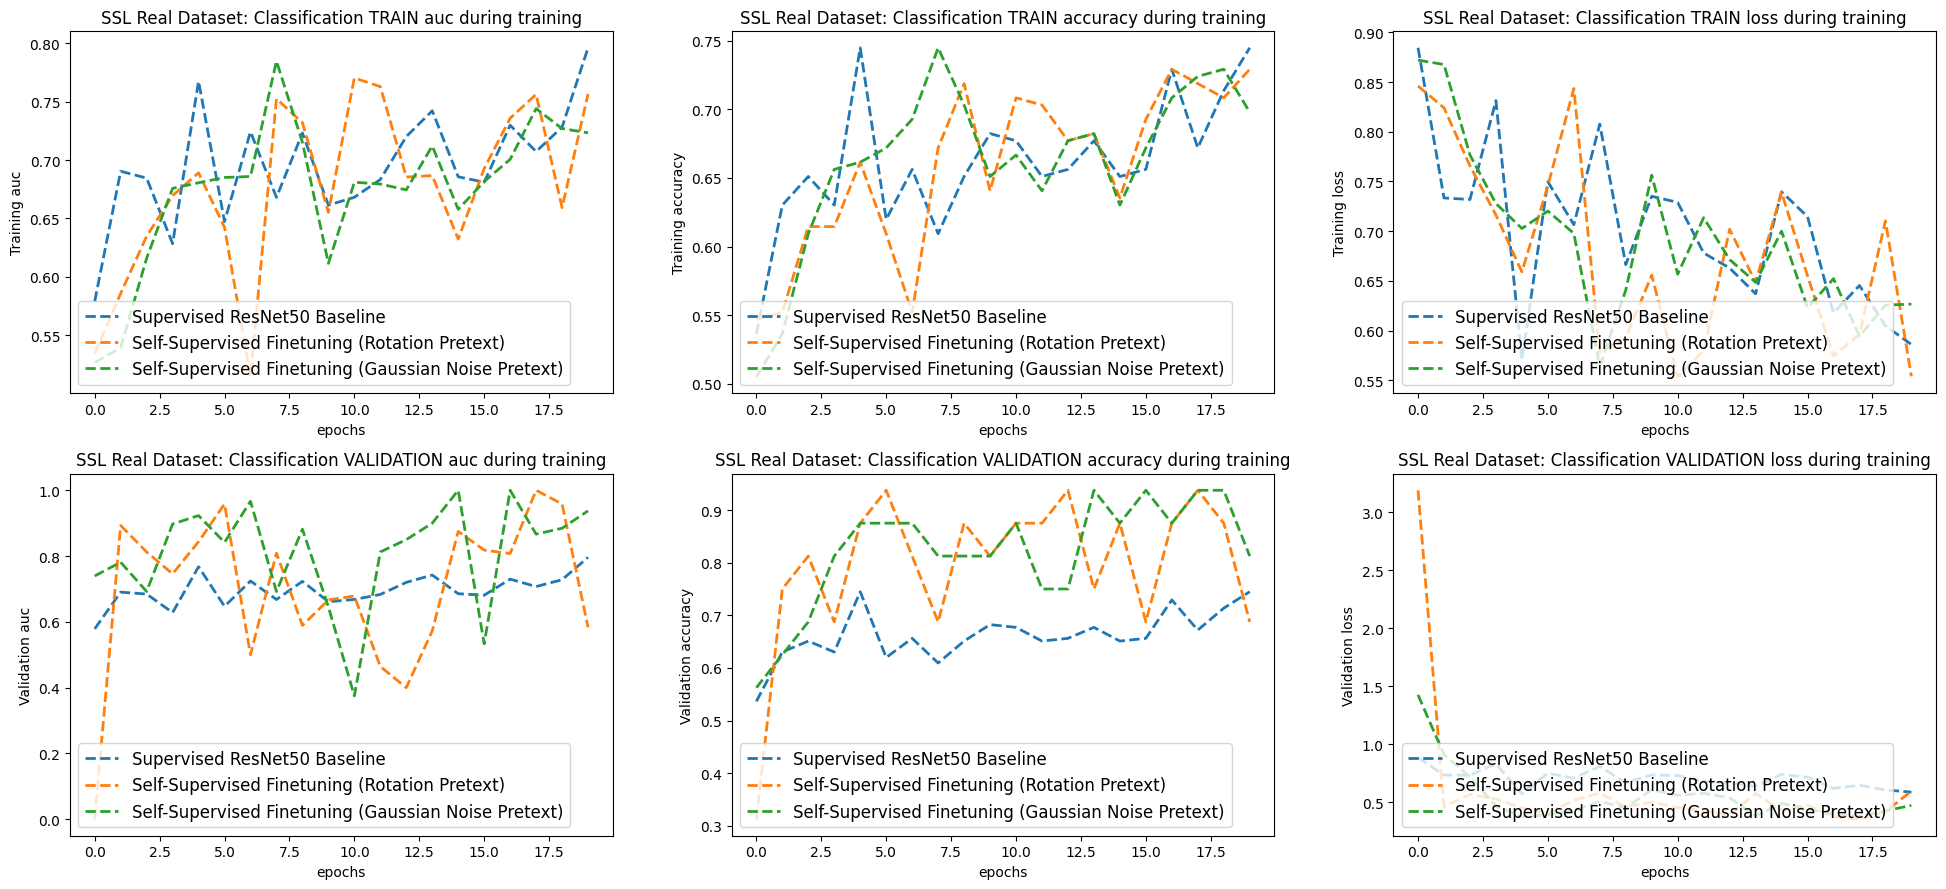

In [55]:
def plot_training_curves(baseline_history, finetuning_history_rotation, finetuning_history_gaussian):
    fig, axes = plt.subplots(2, 3, figsize=(20, 9), dpi=100)
    
    metric_keys = ["auc", "accuracy", "loss"]
    metric_names = ["auc", "accuracy", "loss"]
    
    # Plotting for SSL Real Dataset Training
    for i, (metric_key, metric_name) in enumerate(zip(metric_keys, metric_names)):
        axes[0,i].plot(baseline_history[f"{metric_key}"], label="Supervised ResNet50 Baseline", linestyle='--', linewidth=2)
        axes[0,i].plot(finetuning_history_rotation[f"{metric_key}"], label="Self-Supervised Finetuning (Rotation Pretext)", linestyle='--', linewidth=2)
        axes[0,i].plot(finetuning_history_gaussian[f"{metric_key}"], label="Self-Supervised Finetuning (Gaussian Noise Pretext)", linestyle='--', linewidth=2)

        axes[0,i].legend(fontsize='large', loc='lower left')
        axes[0,i].set_title(f"SSL Real Dataset: Classification TRAIN {metric_name} during training")
        axes[0,i].set_xlabel("epochs")
        axes[0,i].set_ylabel(f"Training {metric_name}")

    # Plotting for SSL Real Dataset Validation
    for i, (metric_key, metric_name) in enumerate(zip(metric_keys, metric_names)):
        axes[1,i].plot(baseline_history[f"{metric_key}"], label="Supervised ResNet50 Baseline", linestyle='--', linewidth=2)
        axes[1,i].plot(finetuning_history_rotation[f"val_{metric_key}"], label="Self-Supervised Finetuning (Rotation Pretext)", linestyle='--', linewidth=2)
        axes[1,i].plot(finetuning_history_gaussian[f"val_{metric_key}"], label="Self-Supervised Finetuning (Gaussian Noise Pretext)", linestyle='--', linewidth=2)

        axes[1,i].legend(fontsize='large', loc='lower left')
        axes[1,i].set_title(f"SSL Real Dataset: Classification VALIDATION {metric_name} during training")
        axes[1,i].set_xlabel("epochs")
        axes[1,i].set_ylabel(f"Validation {metric_name}")
    
    plt.tight_layout()
    plt.show()

plot_training_curves(baseline_history, finetuning_history_rotation, finetuning_history_gaussian)

In [ ]:
baseline_model.load_weights('baseline_model_resnet50.h5')
finetuning_model_rotation.load_weights('finetuning_model_rotation.h5')
finetuning_model_gaussian.load_weights('finetuning_model_gaussian.h5')

In [46]:
val_data_path = '/kaggle/input/gsoc-ssl-2024-test/real_hst'
val_file_paths = [os.path.join(val_data_path, file) for file in os.listdir(val_data_path) if os.path.isfile(os.path.join(val_data_path, file))]
val_generator = image_generator(val_file_paths, label_type='label', batch_size=batch_size)

# baseline_model_results = baseline_model.predict(val_generator, steps=len(val_file_paths), verbose=1)
# finetuning_model_rotation_results = finetuning_model_rotation.predict(val_generator, steps=len(val_file_paths), verbose=1)
# finetuning_model_gaussian_results = finetuning_model_gaussian.predict(val_generator, steps=len(val_file_paths), verbose=1)

In [47]:
num_batches = len(val_file_paths) // batch_size

y_true_baseline = []
y_pred_baseline = []
y_true_finetuning_rotation = []
y_pred_finetuning_rotation = []
y_true_finetuning_gaussian = []
y_pred_finetuning_gaussian = []

for i in range(num_batches):
    X_batch, y_batch = next(val_generator)
    y_true_baseline.extend(y_batch)
    y_pred_baseline.extend(baseline_model.predict(X_batch))
    y_true_finetuning_rotation.extend(y_batch)
    y_pred_finetuning_rotation.extend(finetuning_model_rotation.predict(X_batch))
    y_true_finetuning_gaussian.extend(y_batch)
    y_pred_finetuning_gaussian.extend(finetuning_model_gaussian.predict(X_batch))

# Here is the extra logic for handling the last smaller batch
if len(val_file_paths) % batch_size != 0:
    X_batch, y_batch = next(val_generator)
    y_true_baseline.extend(y_batch)
    y_pred_baseline.extend(baseline_model.predict(X_batch))
    y_true_finetuning_rotation.extend(y_batch)
    y_pred_finetuning_rotation.extend(finetuning_model_rotation.predict(X_batch))
    y_true_finetuning_gaussian.extend(y_batch)
    y_pred_finetuning_gaussian.extend(finetuning_model_gaussian.predict(X_batch))

y_true_baseline = np.array(y_true_baseline)
y_pred_baseline = np.array(y_pred_baseline)
y_true_finetuning_rotation = np.array(y_true_finetuning_rotation)
y_pred_finetuning_rotation = np.array(y_pred_finetuning_rotation)
y_true_finetuning_gaussian = np.array(y_true_finetuning_gaussian)
y_pred_finetuning_gaussian = np.array(y_pred_finetuning_gaussian)

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


W0000 00:00:1712068480.935990     256 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


W0000 00:00:1712068484.808701     256 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


W0000 00:00:1712068488.530495     256 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━

In [67]:
# Calculate AUC
auc_baseline = roc_auc_score(y_true_baseline, y_pred_baseline, average='macro', multi_class='ovr')
auc_finetuning_rotation = roc_auc_score(y_true_finetuning_rotation, y_pred_finetuning_rotation, average='macro', multi_class='ovr')
auc_finetuning_gaussian = roc_auc_score(y_true_finetuning_gaussian, y_pred_finetuning_gaussian, average='macro', multi_class='ovr')

print("Separate test set results (SSL Real Dataset: Containing 5000 samples per class):\n")
print(f"AUC (Baseline): {int(auc_baseline * 1000) / 1000}")  
print(f"AUC (Finetuning Rotation): {int(auc_finetuning_rotation * 1000) / 1000}") 
print(f"AUC (Finetuning Gaussian): {int(auc_finetuning_gaussian * 1000) / 1000}") 

# Calculate accuracy
y_pred_baseline_binary = np.where(y_pred_baseline > 0.5, 1, 0)
y_pred_finetuning_rotation_binary = np.where(y_pred_finetuning_rotation > 0.5, 1, 0)
y_pred_finetuning_gaussian_binary = np.where(y_pred_finetuning_gaussian > 0.5, 1, 0)
accuracy_baseline = accuracy_score(y_true_baseline, y_pred_baseline_binary)
accuracy_finetuning_rotation = accuracy_score(y_true_finetuning_rotation, y_pred_finetuning_rotation_binary)
accuracy_finetuning_gaussian = accuracy_score(y_true_finetuning_gaussian, y_pred_finetuning_gaussian_binary)
print(f"Accuracy (Baseline): {int(accuracy_baseline * 1000) / 10}%")  
print(f"Accuracy (Finetuning Rotation): {int(accuracy_finetuning_rotation * 1000) / 10}%") 
print(f"Accuracy (Finetuning Gaussian): {int(accuracy_finetuning_gaussian * 1000) / 10}%") 


# Print classification report
print("\nSSL Real Dataset: Classification Report (Baseline):")
print(classification_report(y_true_baseline, y_pred_baseline_binary))
print("\nSSL Real Dataset: Classification Report (Finetuning Rotation):")
print(classification_report(y_true_finetuning_rotation, y_pred_finetuning_rotation_binary))
print("\nSSL Real Dataset: Classification Report (Finetuning Gaussian):")
print(classification_report(y_true_finetuning_gaussian, y_pred_finetuning_gaussian_binary))

Separate test set results (SSL Real Dataset: Containing 5000 samples per class):

AUC (Baseline): 0.741
AUC (Finetuning Rotation): 0.779
AUC (Finetuning Gaussian): 0.838
Accuracy (Baseline): 73.1%
Accuracy (Finetuning Rotation): 78.7%
Accuracy (Finetuning Gaussian): 78.7%

SSL Real Dataset: Classification Report (Baseline):
              precision    recall  f1-score   support

           0       0.73      0.99      0.84       153
           1       0.78      0.11      0.19        63

    accuracy                           0.73       216
   macro avg       0.75      0.55      0.52       216
weighted avg       0.74      0.73      0.65       216


SSL Real Dataset: Classification Report (Finetuning Rotation):
              precision    recall  f1-score   support

           0       0.79      0.95      0.86       153
           1       0.76      0.40      0.52        63

    accuracy                           0.79       216
   macro avg       0.77      0.67      0.69       216
weighted av

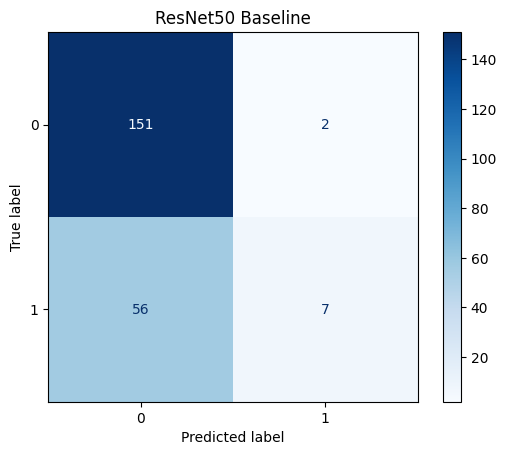

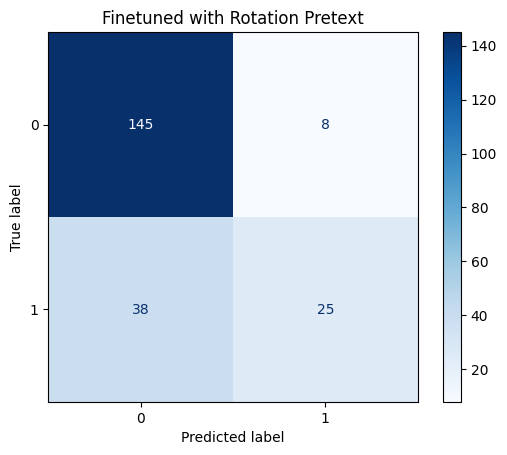

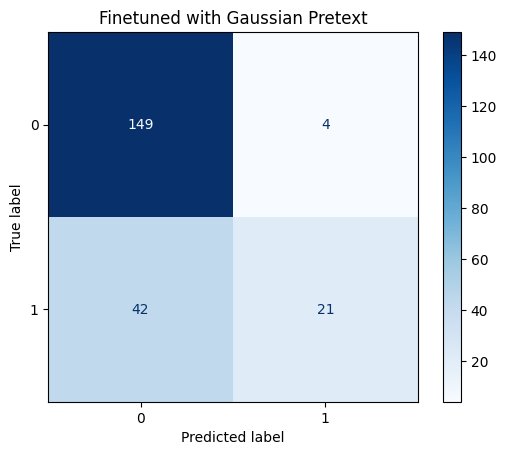

In [87]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def plot_confusion_matrix_custom(y_true, y_pred, title, labels=None,):
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(title)
    plt.show()
plot_confusion_matrix_custom(y_true_baseline, y_pred_baseline_binary, "ResNet50 Baseline")
plot_confusion_matrix_custom(y_true_finetuning_rotation, y_pred_finetuning_rotation_binary, "Finetuned with Rotation Pretext")
plot_confusion_matrix_custom(y_true_finetuning_gaussian, y_pred_finetuning_gaussian_binary, "Finetuned with Gaussian Pretext")


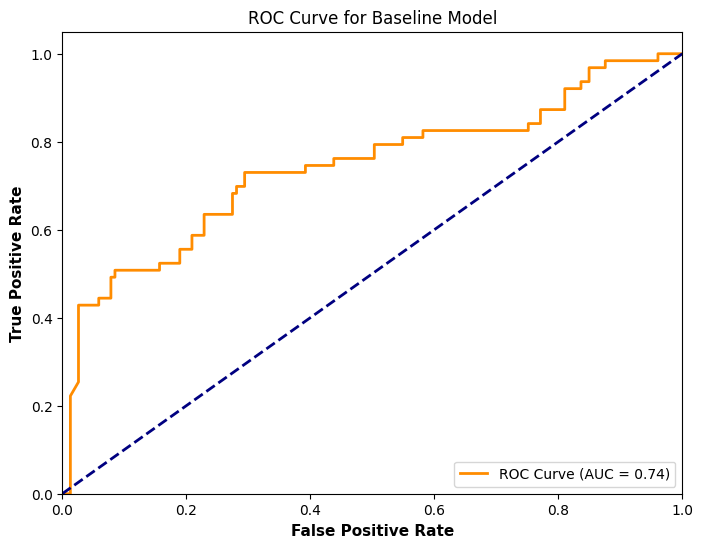

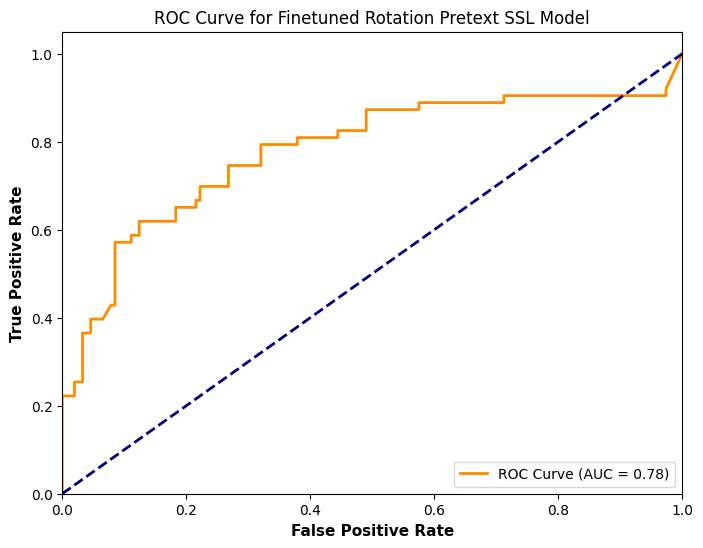

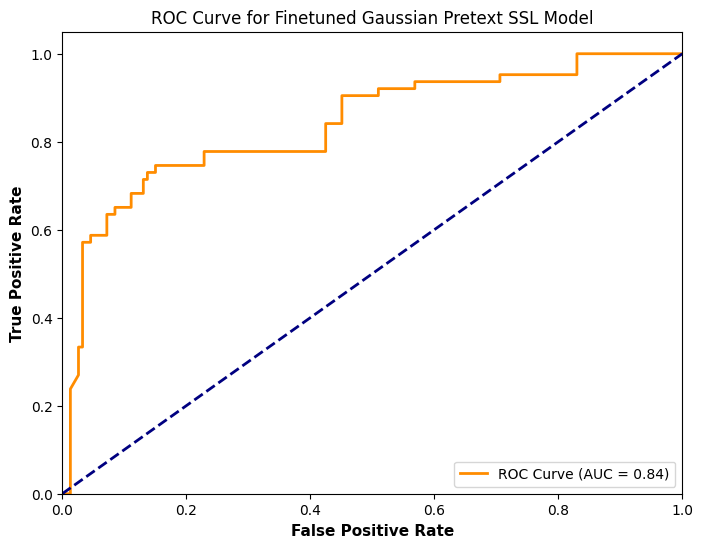

In [101]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

def plot_roc_curve(y_true, y_scores, model_name="Model"):
    # Calculate ROC curve and AUC
    fpr, tpr, _ = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)
    
    # Plot
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2,
             label='ROC Curve (AUC = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve for {model_name}', fontsize=12)
    plt.xlabel('False Positive Rate', fontsize=11, fontweight='bold')
    plt.ylabel('True Positive Rate', fontsize=11, fontweight='bold')
    plt.legend(loc="lower right")
    plt.legend(loc="lower right")
    plt.show()

    return roc_auc

auc_baseline = plot_roc_curve(y_true_baseline, y_pred_baseline, "Baseline Model")
auc_finetuning_rotation = plot_roc_curve(y_true_finetuning_rotation, y_pred_finetuning_rotation, "Finetuned Rotation Pretext SSL Model")
auc_finetuning_gaussian = plot_roc_curve(y_true_finetuning_gaussian, y_pred_finetuning_gaussian, "Finetuned Gaussian Pretext SSL Model")
